In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import itertools
import random
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from PIL import Image

In [3]:
import os

folder_path = '/Users/nousheerwan/Desktop/ml/Sign Language for Numbers'

# Verify that the path is accessible by listing its contents
print(os.listdir(folder_path))

['.DS_Store', '9', '0', '7', '6', '1', '8', '4', '3', '2', '5']


In [22]:
# Define the number of classes, and the paths to the dataset
num_classes = 10
data_path = '/Users/nousheerwan/Desktop/ml/Sign Language for Numbers'

# Define the data generators with validation split
data_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # using 20% of the data for validation
)

# Create the training and validation batches
train_batches = data_gen.flow_from_directory(
    directory=data_path,
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=10,
    shuffle=True,
    subset='training'  # specify this is training data
)

validation_batches = data_gen.flow_from_directory(
    directory=data_path,
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=10,
    shuffle=True,
    subset='validation'  # specify this is validation data
)

Found 12000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


Epoch 1/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.1540 - loss: 2.4987 - val_accuracy: 0.3183 - val_loss: 1.9559 - learning_rate: 0.0010
Epoch 2/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.3440 - loss: 1.8416 - val_accuracy: 0.4673 - val_loss: 1.6713 - learning_rate: 0.0010
Epoch 3/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4791 - loss: 1.4727 - val_accuracy: 0.6120 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 4/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5664 - loss: 1.2439 - val_accuracy: 0.6427 - val_loss: 1.1338 - learning_rate: 0.0010
Epoch 5/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6122 - loss: 1.1252 - val_accuracy: 0.6893 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 6/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6585 - loss: 1.0072 - val_accuracy: 0.7220 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 7/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accura

loss of 0.05431274697184563; compile_metrics of 100.0%
Reloaded model - loss of 0.05431274697184563; compile_metrics of 100.0%


Predictions:
Zero   Four   Four   Zero   Six   Zero   Eight   Three   Six   Two   

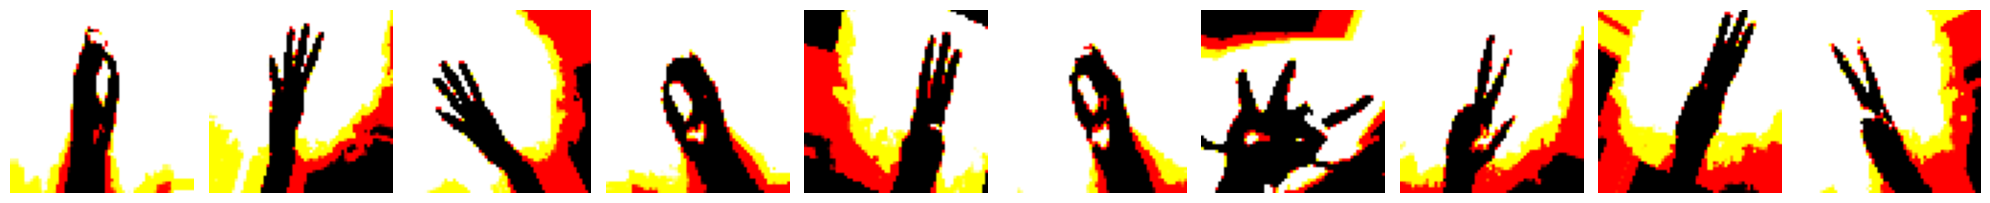

In [23]:
# Define the CNN model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for adaptive learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

# Train the model
history = model.fit(train_batches, epochs=15, callbacks=[reduce_lr, early_stop], validation_data=validation_batches)

# Evaluate the model
imgs, labels = next(validation_batches)
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

# Save the model
model.save('path_to_save/sign_language_best_model.h5')

# Load and evaluate the model
model = tf.keras.models.load_model('path_to_save/sign_language_best_model.h5')
scores = model.evaluate(imgs, labels, verbose=0)
print(f'Reloaded model - {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

# Predictions
predictions = model.predict(imgs, verbose=0)
word_dict = {0: 'Zero', 1: 'One', 2: 'Two', 3: 'Three', 4: 'Four', 5: 'Five', 6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine'}

print("Predictions:")
for ind, i in enumerate(predictions):
    print(f'{word_dict[np.argmax(i)]}', end='   ')

# Display images with predictions
def plotImages(images_arr):
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs[:num_classes]) # Show only 'data_count' number of images

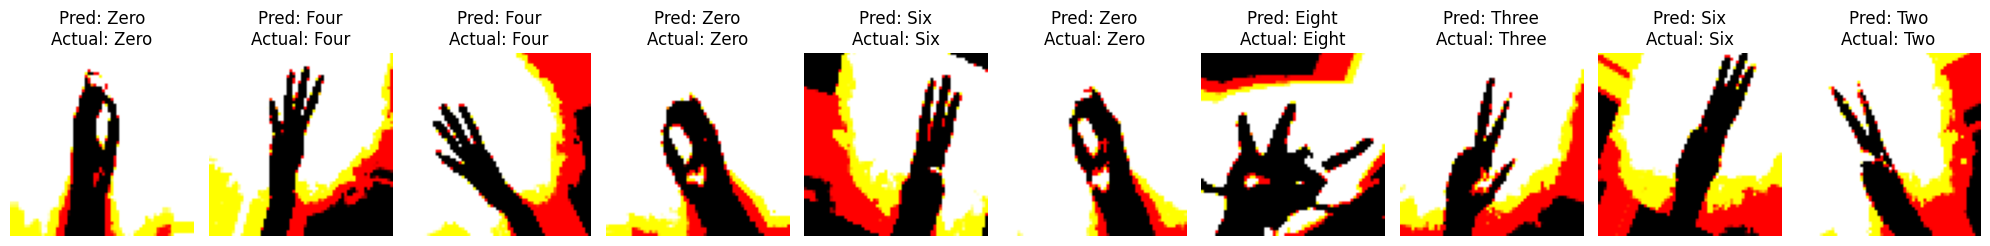

In [26]:
# Display images with predictions and actual labels
def plotImages(images_arr, actual_labels, predictions):
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 20))
    axes = axes.flatten()
    
    for img, label, pred, ax in zip(images_arr, actual_labels, predictions, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Pred: {word_dict[np.argmax(pred)]}\nActual: {word_dict[np.argmax(label)]}')
    
    plt.tight_layout()
    plt.show()

plotImages(imgs[:num_classes], labels[:num_classes], predictions[:num_classes]) 

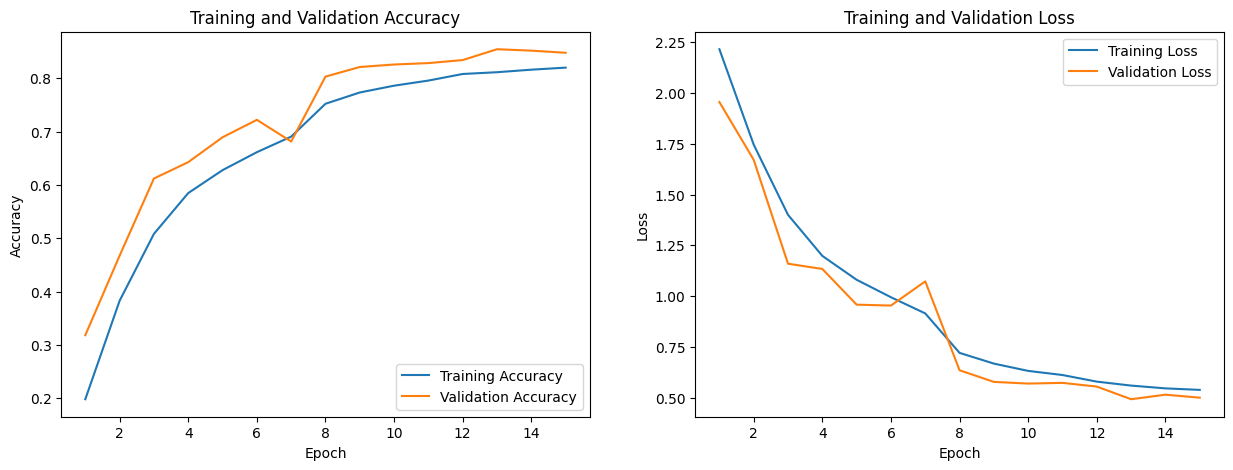

In [25]:
# Extract the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)  # Ensure we have the correct number of epochs

# Plotting training and validation accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
